This notebook shows a basic example of the adaptive resample-move algorithm for sampling from a static Bayesian posterior distribution. It uses the SequentialMonteCarlo.jl package for the SMC implementation.

## The Lotka-Volterra model

This example follows a simple analysis of the Lotka Volterra model for predator and prey populations where the measurement error for the data is assumed to be Gaussian.

$X_{1,t}$ the population of the prey, $X_{2,t}$ the population of the predator at time $t$. These evolve according to:

$$
\frac{dx_1}{dt} = (\alpha -\beta x_2 )x_1 \qquad
\frac{dx_2}{dt} = (\beta x_1 - \gamma )x_2     
$$

Observe a noisy measurement at times $t=0, 2, ..., 50$. 
$$
Y_{1,t} \sim \mathcal{N}(X_{1,t}, \sigma^2), \qquad Y_{2,t} \sim \mathcal{N}(X_{2,t}, \sigma^2)
$$

We implement this model and simulate data with parameters $\alpha=0.3$, $\beta = 0.04$, $\gamma=0.5$ and $\sigma = 1$.

In [1]:
using SequentialMonteCarlo
using Distributions
using DifferentialEquations
using DelimitedFiles
using Statistics
using Plots
using LinearAlgebra
using StatsBase
using StatsPlots

Load in the data and define the sequence of observation times.

In [2]:
y_full = readdlm("prey_pred2.csv", ',', Float64)
n_y = size(y_full,2) - 1 # exclude initial value
ts = 2*(1.0:1.0:n_y) # times steps for data

2.0:2.0:50.0

Define a particle structure for the parameters of the Lotka-Volterra model.

In [3]:
# particle
mutable struct LVParamParticle
    α::Float64 
    β::Float64 
    γ::Float64
    σ::Float64
    LVParamParticle() = new() # initialise empty
end

Base.vec(p::LVParamParticle) = [p.α, p.β, p.γ, p.σ]


Define the prior distribution and a function for evaluating the log-density.

In [4]:
# Prior on θ = [α, β, γ, σ]
priors = product_distribution([Uniform(0., 1), Uniform(0,0.1), Uniform(0, 1), Uniform(0.1, 7)])

function log_prior(θ::Vector{Float64})
    # Prior distributions.
    return sum(logpdf.(priors, θ))
end

log_prior (generic function with 1 method)

Define the Lotka-Volterra ODE model underlying data process (prior to the observation noise).

In [5]:
# Define Lotka-Volterra model.
function lotka_volterra(du, u, p, t)
    # Model parameters.
    α, β, γ = p
    # Current state.
    x, y = u

    # Evaluate differential equations.
    du[1] = (α - β * y) * x # prey
    du[2] = (β * x - γ) * y # predator

    return nothing
end


# Define initial-value problem.
u0 = y_full[:,1]
p_true = [0.5, 0.0025, 0.3, 1.]
tspan = (0.0, 50.0)
prob = ODEProblem(lotka_volterra, u0, tspan, p_true[1:3])


ODEProblem with uType Vector{Float64} and tType Float64. In-place: true
timespan: (0.0, 50.0)
u0: 2-element Vector{Float64}:
 7.06193274
 5.278405814

Define the log-likelihood for the posterior. This uses the forward process with multivariate normal observation noise.

In [6]:
y = y_full[:,2:end]
temps = 0.8 .^ (12:-1:0)
n = length(temps) - 1

function log_like(θ::Vector{Float64})
    p = θ[1:3]
    σ = θ[4]
    # Simulate Lotka-Volterra model. 
    predicted = solve(prob; p=p, saveat = ts, verbose=false)

    if !SciMLBase.successful_retcode(predicted.retcode)
        #println(p)
        return -Inf
    end

    # Add up the log likelihood
    log_likelihood = 0.0
    for i in eachindex(predicted)
        like_dist = MvNormal(predicted[:,i], σ^2 * I)
        log_likelihood += logpdf(like_dist, y[:,i])
    end
    return log_likelihood
end

log_like (generic function with 1 method)

Define a proposal distributions for the MCMC kernel. The function takes input as the current particle location and outputs a multivariate normal distribution to draw a sample from.

In [7]:

function proposal(currθ::Vector{Float64})
    return MvNormal(currθ, 0.25^2 * I)
end

proposal (generic function with 1 method)

Define the MCMC kernel itself, which uses the above proposal. It is a random-walk Metropolis-Hastings kernel.

In [8]:
# Metropolis-Hastings Kernel with Random Walk proposal
# Posterior = prior(θ) * likelihood(θ)ᵝ
function mh(rng, currθ::Vector{Float64}, propθ::Vector{Float64}, β::Float64)
    lp_curr = logpdf(priors, currθ) + β * log_like(currθ)
    lp_prop = logpdf(priors, propθ) + β * log_like(propθ)
    if lp_prop - lp_curr > log(rand(rng))
        return propθ
    else
        return currθ
    end
end

mh (generic function with 1 method)

Here we define the (initial distribution and) mutation kernel for the SMC algorithm. Time $t=1$ indicates the initial distribution, whilst $t>1$ are the mutation steps.

In [9]:
# mutation kernel
function M!(new::LVParamParticle, rng, t::Int64, old::LVParamParticle, ::Nothing)
    if t == 1
        θ = rand(rng, priors)
    else
        # proposal
        propθ = rand(rng, proposal(vec(old)))
        θ = mh(rng, vec(old), propθ, temps[t])
    end

    new.α, new.β, new.γ, new.σ = θ

end

M! (generic function with 1 method)

Lastly, we define the potential function (on the log-scale). Since we are annealing from the prior distribution we only considered the incremental change in the log-likelihood. 

In [10]:

# potential function
function lG(t::Int64, particle::LVParamParticle, ::Nothing)
    β_incr = temps[t+1] - temps[t]
    return β_incr * log_like(vec(particle))
end

lG (generic function with 1 method)

Now we set some algorithmic parameters for the SMC run.

In [11]:

N = 2^10        # number of particles
threads = 1     # number of threads
κ = 0.5         # relative ESS threshold
saveall = true  # save full trajectory 


true

Finally, define the model for our SMC algorithm...

In [12]:
model = SMCModel(M!, lG, n, LVParamParticle, Nothing)

SMCModel{typeof(M!), typeof(lG)}(M!, lG, 12, LVParamParticle, Nothing)

... and space to save the output.

In [13]:
smcio = SMCIO{model.particle, model.pScratch}(N, n, threads, saveall, κ)

SMCIO{LVParamParticle, Nothing}(1024, 12, 1, LVParamParticle[LVParamParticle(1.5e-323, 2.371935704e-314, 2.330071759e-314, 0.0), LVParamParticle(1.5e-323, 2.361767841e-314, 2.3623547356e-314, 0.0), LVParamParticle(1.5e-323, 2.361767841e-314, 2.3623547356e-314, 0.0), LVParamParticle(1.5e-323, 2.371935704e-314, 2.330071759e-314, 0.0), LVParamParticle(1.5e-323, 2.371935704e-314, 2.330071759e-314, 0.0), LVParamParticle(1.5e-323, 2.371935704e-314, 2.330071759e-314, 0.0), LVParamParticle(1.5e-323, 2.371935704e-314, 2.330071759e-314, 0.0), LVParamParticle(1.5e-323, 2.371935704e-314, 2.330071759e-314, 0.0), LVParamParticle(1.5e-323, 2.371935704e-314, 2.330071759e-314, 0.0), LVParamParticle(1.5e-323, 2.371935704e-314, 2.330071759e-314, 0.0)  …  LVParamParticle(1.5e-323, 2.371935704e-314, 2.330071759e-314, 0.0), LVParamParticle(1.5e-323, 2.371935704e-314, 2.330071759e-314, 0.0), LVParamParticle(1.5e-323, 2.371935704e-314, 2.330071759e-314, 0.0), LVParamParticle(1.5e-323, 2.371935704e-314, 2.3300

Finally, we can run the SMC algorithm with our settings.

In [14]:
smc!(model, smcio)

We can extract the terminal particles as a matrix and calculate the mean and variance.

In [21]:

ps = Matrix(hcat(vec.(smcio.zetas)...)')
ws = Weights(smcio.ws)

# mean and cov
μ = mean(ps, ws, dims = 1)
Σ = cov(ps, ws)

1024×4 Matrix{Float64}:
 0.280254  0.0433527  0.543171  4.98116
 0.280254  0.0433527  0.543171  4.98116
 0.280254  0.0433527  0.543171  4.98116
 0.280254  0.0433527  0.543171  4.98116
 0.280254  0.0433527  0.543171  4.98116
 0.280254  0.0433527  0.543171  4.98116
 0.280254  0.0433527  0.543171  4.98116
 0.280254  0.0433527  0.543171  4.98116
 0.280254  0.0433527  0.543171  4.98116
 0.280254  0.0433527  0.543171  4.98116
 ⋮                              
 0.280254  0.0433527  0.543171  4.98116
 0.280254  0.0433527  0.543171  4.98116
 0.250662  0.0599671  0.690241  2.62888
 0.250662  0.0599671  0.690241  2.62888
 0.250662  0.0599671  0.690241  2.62888
 0.250662  0.0599671  0.690241  2.62888
 0.250662  0.0599671  0.690241  2.62888
 0.360486  0.0382264  0.398661  2.87234
 0.360486  0.0382264  0.398661  2.87234

And there is functionality in SequentialMonteCarlo.jl to do this automatically.

In [16]:
SequentialMonteCarlo.eta(smcio, p -> vec(p), true, n)

4-element Vector{Float64}:
 0.28027370922755945
 0.04335757243875815
 0.5431742153076241
 4.9793225862693635

We can look at density plots too

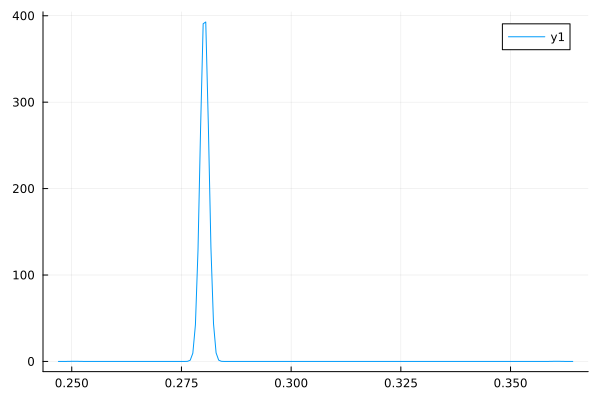

In [25]:
density(ps[:,1], weights = ws)